# Предсказание стартапов

# Цели и задачи

Были предоставлены табличные данные, в которых указана информация о стартапах, которые функционировали в период с 1980 по 2018 год. Необходимо произвести обработку этих данных, провести исследовательский анализ и итогом данной работы будет является модель машинного обучения, которая будет предсказывать продолжение деятельности стартапа. (Признак status)

## Загрузка библиотек и предварительный просмотр файлов

In [1]:
# Библиотеки для преодобработки и исследования данных

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy import stats as st
from scipy.stats import binom
import random
from collections import Counter
from datetime import datetime


import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap

# Подготовка данных для МО
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance

# Модели МО
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

# Метрики для МО
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score,\
confusion_matrix, recall_score, precision_score, root_mean_squared_error, make_scorer, roc_auc_score

In [2]:
plt.rcParams["figure.figsize"] = (15, 6)

In [3]:
try:
    sample = pd.read_csv('/Users/oleg/Desktop/Kaggle/kaggle_startups_sample_submit_28062024.csv')
except:
    print('Loading error')

In [4]:
try:
    test = pd.read_csv('/Users/oleg/Desktop/Kaggle/kaggle_startups_test_28062024.csv')
except:
    print('Loading error')

In [5]:
try:
    train = pd.read_csv('/Users/oleg/Desktop/Kaggle/kaggle_startups_train_28062024.csv')
except:
    print('Loading error')

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
В данном проекте датасет sample является примером, для того, как должен выглядеть результат работы модели. Поэтому исследовать и проверять его не нужно.
</div>

### Train

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [7]:
train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


### Test

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [9]:
test.head(10)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,160000.0,NaN,NaN,NaN,NaN,2,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,26842000.0,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,4000000.0,NaN,NaN,NaN,NaN,1,2003-06-02,2003-06-02,5576
8,Urgent.ly,Software,8710000.0,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,13200.0,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057


## Предобработка train

In [10]:
train.duplicated().sum()

np.int64(0)

In [11]:
train['name'].nunique()

52515

In [12]:
train['category_list'] = train['category_list'].str.replace('|', ', ')

In [13]:
train['category_list']

0                Online Reservations, Restaurants
1         Manufacturing, Medical, Medical Devices
2                                   Biotechnology
3                                     Health Care
4                                   Manufacturing
                           ...                   
52511                               Entertainment
52512                                 Hospitality
52513     Email, Messaging, Productivity Software
52514                                    Security
52515    Online Rental, Parking, Price Comparison
Name: category_list, Length: 52516, dtype: object

In [14]:
train['category_list'].isna().sum()

np.int64(2465)

In [15]:
train['funding_total_usd'].nunique()

15551

In [16]:
train['funding_total_usd'].isna().sum()

np.int64(10069)

In [17]:
train['status'].unique()

array(['operating', 'closed'], dtype=object)

In [18]:
train['status'].isna().sum()

np.int64(0)

In [19]:
train['country_code'].sort_values().unique()

array(['ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BAH', 'BEL',
       'BGD', 'BGR', 'BHR', 'BLM', 'BLR', 'BLZ', 'BMU', 'BRA', 'BRN',
       'BWA', 'CAN', 'CHE', 'CHL', 'CHN', 'CMR', 'COL', 'CRI', 'CYM',
       'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP',
       'EST', 'FIN', 'FRA', 'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GRC',
       'GRD', 'GTM', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IND', 'IRL',
       'IRN', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ',
       'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LIE', 'LKA',
       'LTU', 'LUX', 'LVA', 'MAF', 'MAR', 'MCO', 'MDA', 'MEX', 'MKD',
       'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MYS', 'NGA', 'NIC', 'NLD',
       'NOR', 'NPL', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'POL',
       'PRI', 'PRT', 'PRY', 'PSE', 'QAT', 'ROM', 'RUS', 'RWA', 'SAU',
       'SEN', 'SGP', 'SLV', 'SOM', 'SRB', 'SVK', 'SVN', 'SWE', 'SYC',
       'TAN', 'TGO', 'THA', 'TTO', 'TUN', 'TUR', 'TWN', 'UGA', 'UKR',
       'URY', 'USA',

In [20]:
train['country_code'].isna().sum()

np.int64(5502)

In [21]:
train['state_code'].unique()

array(['25', 'CA', nan, 'VA', 'NJ', 'TX', 'OR', 'FL', 'WA', 'NY', 'C7',
       'AZ', '91', 'GA', 'MA', 'PA', 'MI', '56', 'MN', 'A8', 'DE', '26',
       'Q5', '7', 'RI', '11', 'C5', 'CO', '3', '23', '1', 'ON', 'IL',
       'OH', 'K2', '2', '14', '30', 'H9', 'AL', '29', '6', 'NC', '5',
       '12', '22', 'MD', '48', 'ND', '40', 'K4', 'VT', '16', '4', 'UT',
       'IN', '8', '9', '18', 'CT', '13', 'NV', '10', 'B8', '27', '17',
       'IA', 'WI', 'L9', 'NM', 'B7', 'MO', 'BC', '21', 'F7', 'ME', 'NH',
       '35', 'NS', 'C1', 'C3', 'SC', '20', 'TN', 'A6', '51', 'I7', 'LA',
       'KS', '42', 'N7', 'U8', 'I2', 'AR', '19', 'NE', '41', 'QC', 'AB',
       '37', '15', '97', 'V2', 'D2', 'DC', 'A7', 'C9', 'F8', 'Y2', 'B9',
       'J7', 'M9', 'G2', 'H3', 'ID', 'NB', '28', 'V8', '34', 'B5', 'F2',
       'A9', 'Z7', '53', 'H8', 'MT', 'MB', 'KY', '61', '60', 'B4', 'H7',
       '82', 'A2', 'C8', 'L3', 'B3', 'D9', 'M3', 'MS', '31', '33', '52',
       'HI', 'AK', '78', '72', 'Q4', 'Y4', 'WY', '32', 'E6', 

In [22]:
train['region'].sort_values().unique().tolist()

['A Coruna',
 'AB - Other',
 'AK - Other',
 'AL - Other',
 'AR - Other',
 'ARG - Other',
 'ARM - Other',
 'AUS - Other',
 'AUT - Other',
 'AZ - Other',
 'AZE - Other',
 'Aachen',
 'Aalborg',
 'Aarhus',
 'Abbotsford',
 'Aberdeen',
 'Abu Dhabi',
 'Abuja',
 'Accra',
 'Adelaide',
 'Admiralty',
 'Ahmedabad',
 'Aix-en-provence',
 'Akron - Canton',
 'Albany, Georgia',
 'Albany, New York',
 'Albuquerque',
 'Alcester',
 'Alcorcon',
 'Alcoy',
 'Aldershot',
 'Alexandria',
 'Alfreton',
 'Alicante',
 'Allentown',
 'AllerÃ¸d',
 'Almeria',
 'Altrincham',
 'Amersham',
 'Amman',
 'Amsterdam',
 'Anaheim',
 'Anchorage',
 'Ancona',
 'Ankara',
 'Annecy',
 'Antwerp',
 'Asheville',
 'Athens',
 'Athens, Georgia',
 'Atlanta',
 'Atlantic City',
 'Auckland',
 'Augsburg',
 'Austin',
 'Ayr',
 'BC - Other',
 'BEL - Other',
 'BGR - Other',
 'BHS - Other',
 'BLM - Other',
 'BLZ - Other',
 'BRA - Other',
 'BWA - Other',
 'Baar',
 'Bahamas',
 'Bahrain',
 'Bakersfield',
 'Baku',
 'Ballerup',
 'Balmain',
 'Baltimore',
 '

In [23]:
train['city'].unique()

array(['Zürich', 'Redwood City', 'San Jose', ..., 'Circleville',
       'Doncaster', 'Centreville'], shape=(4478,), dtype=object)

In [24]:
train['funding_rounds'].unique()

array([ 2,  4,  3,  1,  5,  7,  9,  6,  8, 10, 11, 12, 15, 13, 16, 17, 14,
       18, 19])

In [25]:
train['founded_at'].sort_values(ascending = True).unique()

array(['1970-02-05', '1970-06-04', '1971-01-01', ..., '2015-12-23',
       '2016-01-01', '2016-04-02'], shape=(5402,), dtype=object)

In [26]:
train['first_funding_at'].sort_values(ascending = True).unique()

array(['1977-05-15', '1979-01-01', '1982-03-20', ..., '2015-12-03',
       '2015-12-04', '2015-12-05'], shape=(4603,), dtype=object)

In [27]:
train['last_funding_at'].sort_values(ascending = True).unique()

array(['1977-05-15', '1979-01-01', '1982-03-20', ..., '2015-12-04',
       '2015-12-05', '2015-12-07'], shape=(4305,), dtype=object)

In [28]:
train['closed_at'].sort_values(ascending = True).unique()

array(['1983-10-06', '1983-12-14', '1985-05-19', ..., '2017-10-11',
       '2017-10-21', nan], shape=(3009,), dtype=object)

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
В условии задачи сказано, что нужно проанализировать данные с 1980 года, но в столбце founded_at есть компании, которые основаны ранее указанного срока, следовательно необходимо избавиться от них.   
</div>

In [29]:
train = train.query('founded_at >= "1980-01-01"')

In [30]:
train['founded_at'].sort_values(ascending = True).unique()

array(['1980-01-01', '1980-05-01', '1980-09-19', ..., '2015-12-23',
       '2016-01-01', '2016-04-02'], shape=(5374,), dtype=object)

In [31]:
train['first_funding_at'].sort_values(ascending = True).unique()

array(['1982-03-20', '1982-12-01', '1983-06-01', ..., '2015-12-03',
       '2015-12-04', '2015-12-05'], shape=(4586,), dtype=object)

In [32]:
train['last_funding_at'].sort_values(ascending = True).unique()

array(['1982-03-20', '1982-12-01', '1983-06-01', ..., '2015-12-04',
       '2015-12-05', '2015-12-07'], shape=(4289,), dtype=object)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
Несостыковок в датах нет. ✔️
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
Далее можно попробовать восстановить информацию о регионах и кодах страны по формуле:
Если известен код страны, то регион (код - Other).
А если регион известен, то и страну можно найти.
</div>

In [33]:
df = train.copy().query('@pd.isna(region) and @pd.notna(country_code)')

In [34]:
df_rest = train.copy().query('not (@pd.isna(region) and @pd.notna(country_code))')

In [35]:
df['region'] = df['country_code'] + ' - Other'

In [36]:
train = pd.concat([df, df_rest]).reset_index(drop=True)

In [37]:
train.query('@pd.isna(region) and @pd.notna(country_code)')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
Данные о коде страны, регионе или городе были заполнены насколько возможно ✔️
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
Необходимо классифицировать деятельность компаний.

Для этого был сделан счетчик уникальных названий, и те значения, который встречались чаще всего были вставлены в функцию. Таким образом было получено 18 основных категорий + пропуски.
</div>

In [38]:
def categorize_list(row):
    try:
        if 'Software' in row:
            return 'Software'
        elif 'Biotechnology' in row:
            return 'Biotechnology'
        elif 'Mobile' in row:
            return 'Mobile'
        elif 'App' in row:
            return 'App'
        elif 'Analytics' in row:
            return 'Analytics'
        elif 'E-Commerce' in row:
            return 'E-Commerce'
        elif 'Clean Technology' in row:
            return 'Clean Technology'
        elif 'Curated Web' in row:
            return 'Curated Web'
        elif 'Manufacturing' in row:
            return 'Manufacturing'
        elif 'Advertising' in row:
            return 'Advertising'
        elif 'Education' in row:
            return 'Education'
        elif 'Semiconductors' in row:
            return 'Semiconductors'
        elif 'Finance' in row:
            return 'Finance'
        elif 'Real Estate' in row:
            return 'Real Estate'
        elif 'Social Media' in row:
            return 'Social Media'
        elif 'Consulting' in row:
            return 'Consulting'
        elif 'Security' in row:
            return 'Security'
        elif 'Games' or 'Game' in row:
            return 'Games'
        else:
            return row
    except:
        pass

In [39]:
train['cat_list'] = train['category_list'].apply(categorize_list)

In [40]:
counter = Counter(train['cat_list'])

In [41]:
print(counter)

Counter({'Games': 15489, 'Software': 10219, 'Mobile': 4405, 'Biotechnology': 3644, 'E-Commerce': 2785, None: 2451, 'Curated Web': 1973, 'Advertising': 1301, 'Analytics': 1235, 'Education': 1175, 'Clean Technology': 1151, 'Finance': 1124, 'Social Media': 1095, 'App': 1007, 'Manufacturing': 956, 'Security': 729, 'Real Estate': 586, 'Consulting': 525, 'Semiconductors': 491})


### Добавим новые колонки

In [42]:
train['founded_at'] = pd.to_datetime(train['founded_at'])

In [43]:
train['first_funding_at'] = pd.to_datetime(train['first_funding_at'])

In [44]:
train['last_funding_at'] = pd.to_datetime(train['last_funding_at'])

In [45]:
train['founding_year'] = train['founded_at'].dt.year

In [46]:
train['first_funding_year'] = train['first_funding_at'].dt.year

In [47]:
train['last_funding_year'] = train['last_funding_at'].dt.year

In [48]:
train['mean_funding'] = train['funding_total_usd'] / train['funding_rounds']

## Обработка столбца closed_at

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
Пропуски в столбце closed_at обусловлены тем, что компании являются до сих пор открытыми, поэтому заполним пропуски текущей датой и высчитаем lifetime
</div>

In [49]:
train['closed_at'] = train['closed_at'].fillna(datetime.today())

In [50]:
train['closed_at'] = pd.to_datetime(train['closed_at'])

In [51]:
train['close_year'] = train['closed_at'].dt.year

In [52]:
train['lifetime'] = (train['closed_at'] - train['founded_at']).dt.days

## Предобработка test

### Добавим новые колонки

In [53]:
test['category_list'] = test['category_list'].str.replace('|', ', ')

In [54]:
test['cat_list'] = test['category_list'].apply(categorize_list)

In [55]:
test['first_funding_at'] = pd.to_datetime(test['first_funding_at'])

In [56]:
test['last_funding_at'] = pd.to_datetime(test['last_funding_at'])

In [57]:
test['first_funding_year'] = test['first_funding_at'].dt.year

In [58]:
test['last_funding_year'] = test['last_funding_at'].dt.year

In [59]:
test['mean_funding'] = test['funding_total_usd'] / test['funding_rounds']

## Исследование с помощью describe()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
Для того, чтобы проанализировать выбросы в количественных данных в данном случае достаточно использовать метод describe. Если не брать в рассчет данные с датами, которые уже были посмотрены и изучены, то метода describe будет вполне достаточно.
</div>

In [60]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
funding_total_usd,42321.0,18156517.696783,1.0,335000.0,2000000.0,10000000.0,30079503000.0,187232682.11607
funding_rounds,52341.0,1.742057,1.0,1.0,1.0,2.0,19.0,1.375495
founded_at,52341,2008-12-14 16:41:58.988937984,1980-01-01 00:00:00,2006-11-02 00:00:00,2010-10-03 00:00:00,2013-01-01 00:00:00,2016-04-02 00:00:00,NaN
first_funding_at,52341,2011-07-20 00:45:26.978850304,1982-03-20 00:00:00,2009-10-14 00:00:00,2012-07-24 00:00:00,2014-04-01 00:00:00,2015-12-05 00:00:00,NaN
last_funding_at,52341,2012-07-01 00:43:34.730326272,1982-03-20 00:00:00,2011-02-01 00:00:00,2013-09-01 00:00:00,2014-11-17 00:00:00,2015-12-07 00:00:00,NaN
closed_at,52341,2024-02-04 17:55:53.985989632,1983-10-06 00:00:00,2025-05-04 15:47:18.135185920,2025-05-04 15:47:18.135185920,2025-05-04 15:47:18.135185920,2025-05-04 15:47:18.135186,NaN
founding_year,52341.0,2008.669628,1980.0,2006.0,2010.0,2013.0,2016.0,5.442865
first_funding_year,52341.0,2011.083586,1982.0,2009.0,2012.0,2014.0,2015.0,3.59274
last_funding_year,52341.0,2012.021761,1982.0,2011.0,2013.0,2014.0,2015.0,3.313063
mean_funding,42321.0,8811747.411162,1.0,250000.0,1300000.0,5650000.0,10664943639.0,84698135.295357


In [61]:
test.describe().T

,count,mean,min,25%,50%,75%,max,std
funding_total_usd,10547.0,16549102.695138,1.0,320000.0,2000000.0,10000000.0,4715000000.0,92172825.631754
funding_rounds,13125.0,1.714438,1.0,1.0,1.0,2.0,15.0,1.3188
first_funding_at,13125,2011-07-23 20:54:08.640000,1973-04-15 00:00:00,2009-11-16 00:00:00,2012-08-01 00:00:00,2014-04-01 00:00:00,2015-12-03 00:00:00,NaN
last_funding_at,13125,2012-06-16 05:03:41.348571392,1973-04-15 00:00:00,2011-01-10 00:00:00,2013-08-21 00:00:00,2014-11-11 00:00:00,2015-12-12 00:00:00,NaN
lifetime,13125.0,3097.609524,52.0,1726.0,2526.0,3866.0,17167.0,2128.356554
first_funding_year,13125.0,2011.094324,1973.0,2009.0,2012.0,2014.0,2015.0,3.644952
last_funding_year,13125.0,2011.98141,1973.0,2011.0,2013.0,2014.0,2015.0,3.392035
mean_funding,10547.0,8234822.49941,1.0,250000.0,1287500.0,5478212.166667,3500000000.0,56855172.016381


## Корреляция

In [62]:
cols_to_drop = ['name', 'category_list', 'founded_at', 'first_funding_at', 'last_funding_at',
                'closed_at', 'city', 'region']

In [63]:
interval_cols = ['funding_total_usd', 'funding_rounds', 'founding_year', 'first_funding_year',
            'last_funding_year', 'close_year', 'lifetime', 'mean_funding']

In [64]:
phik_overview = phik_matrix(train.drop(cols_to_drop, axis=1), interval_cols=interval_cols)

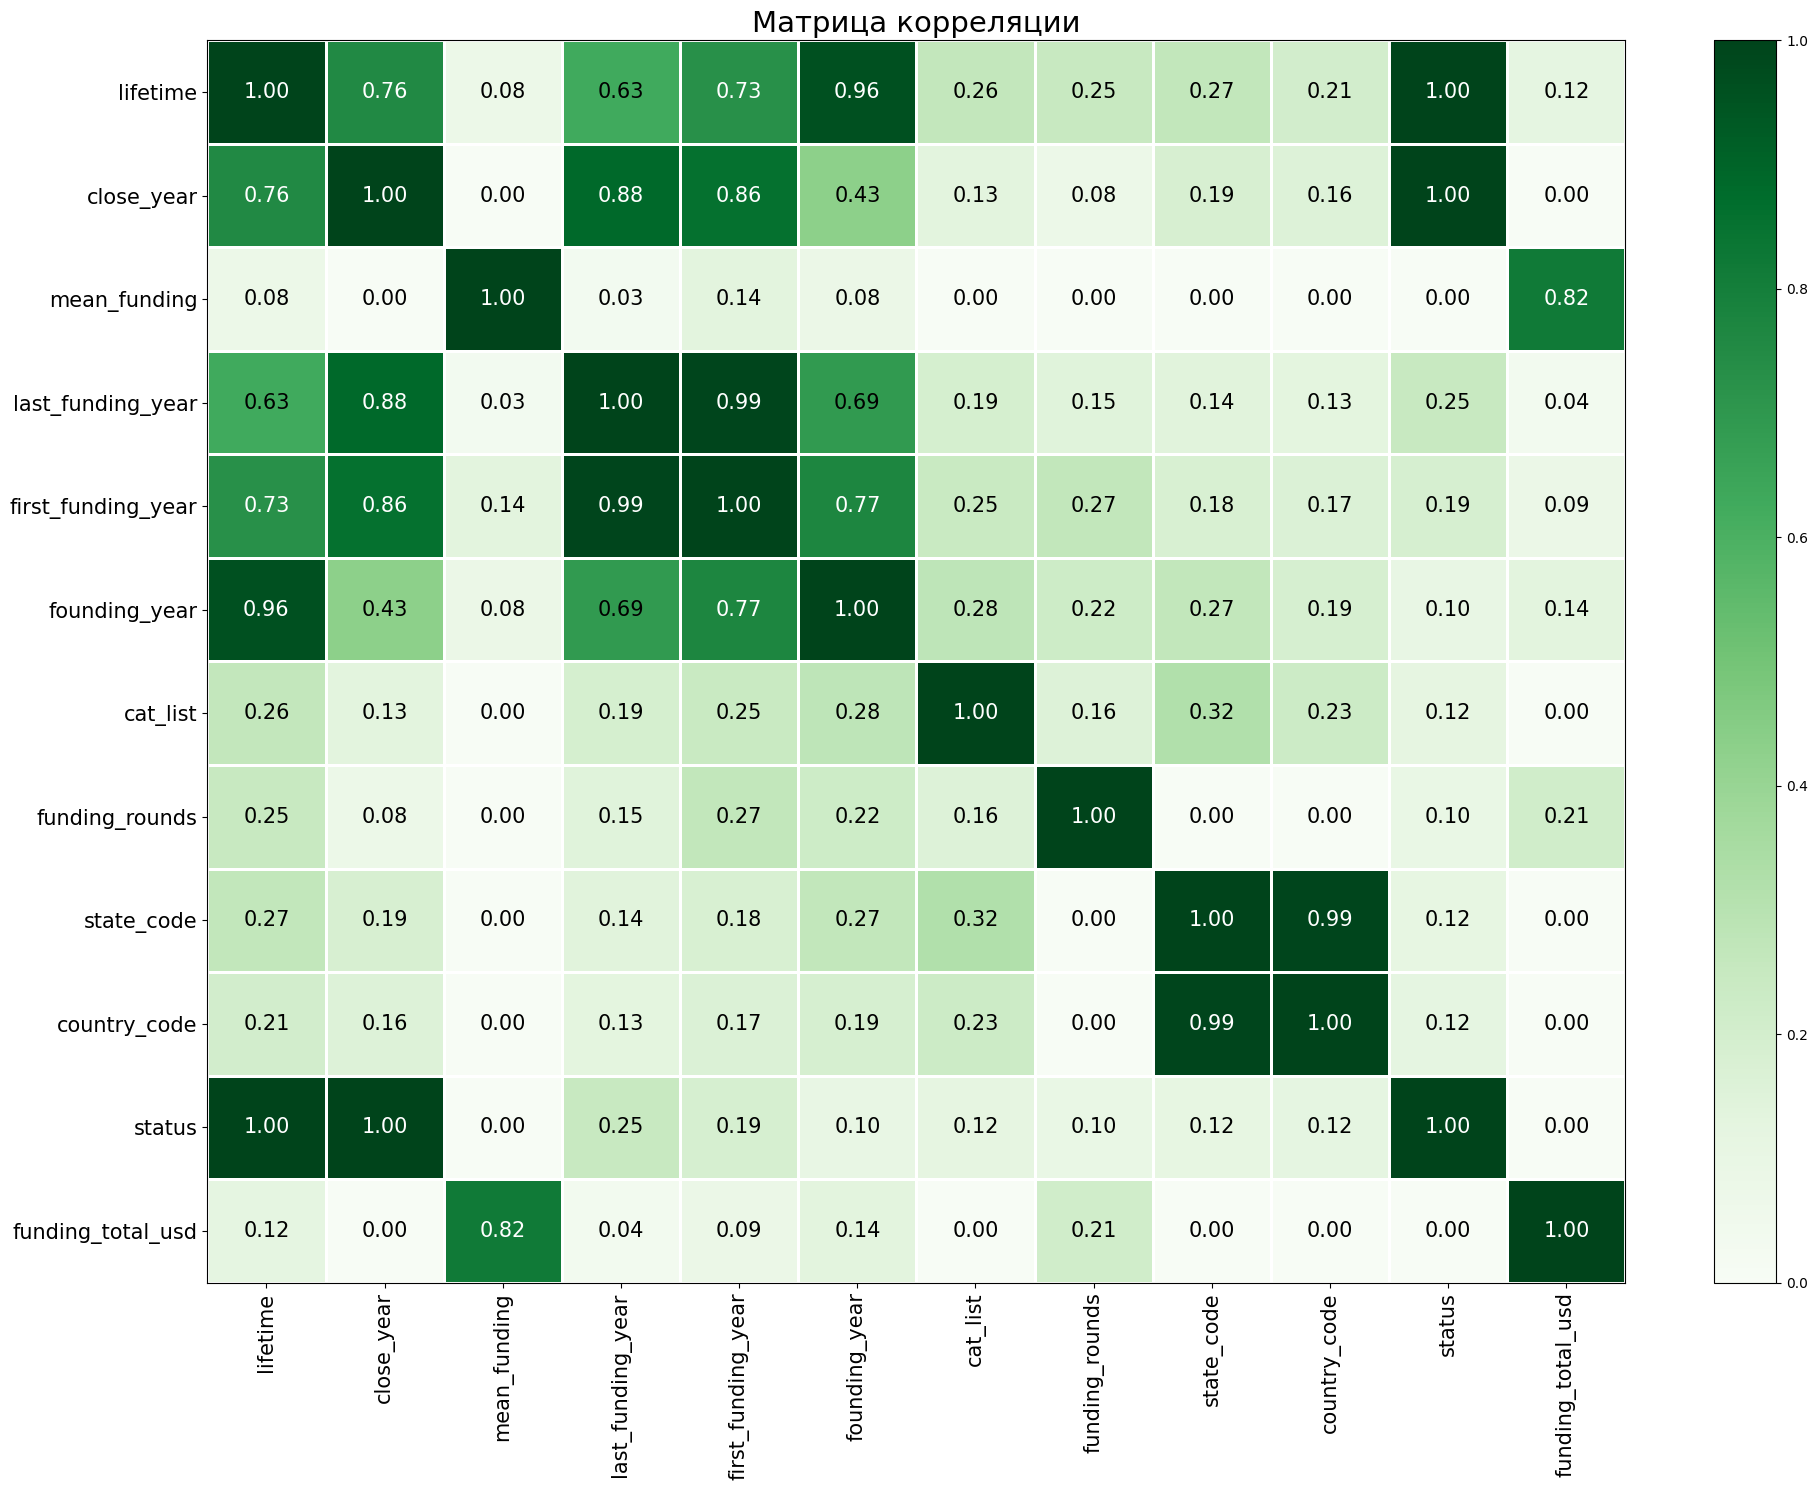

In [65]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='Матрица корреляции',
    fontsize_factor=1.5,
    figsize=(20, 15)
)
plt.show()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
Корреляция целевого признака очень низкая. Практически отсутствует.
Однако есть очень сильная зависимость между годом открытия компании и годом закрытия. И между годом открытия и временем работы. 
</div>

## ML модель

### Подготовка данных

In [66]:
def replace_inf(df):
    return df.replace([np.inf, -np.inf, None], np.nan)

In [67]:
def num_status(df):
    if df == 'closed':
        return 0
    elif df == 'operating':
        return 1
    else:
        np.nan

In [68]:
train['num_status'] = train['status'].apply(num_status)

In [69]:
train = train.sort_index(axis=1)

In [70]:
test = test.sort_index(axis=1)

### Разделение на тренировочную и тестовую выборки

In [71]:
X = train.drop(cols_to_drop, axis=1).drop(['status', 'founding_year', 'close_year',
                                           'num_status'], axis=1)

In [72]:
y = train['status']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [74]:
num_cols = ['first_funding_year', 'funding_rounds', 'last_funding_year', 'lifetime', 'mean_funding',
            'funding_total_usd']
cat_cols = ['country_code', 'state_code', 'cat_list']

### Пайплайн

In [75]:
def replace_inf(df):
    return df.replace([np.inf, -np.inf], np.nan)

In [76]:
train = replace_inf(train)

In [77]:
test = replace_inf(test)

In [78]:
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [79]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('num', StandardScaler())
])

In [80]:
data_prepare = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
], remainder='passthrough')

In [81]:
final_pipe = Pipeline(steps = [
    ('preprocessor', data_prepare),
    ('model', KNeighborsClassifier(n_neighbors=60))
])

In [82]:
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code', 'state_code',
                                                   'cat_list']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['first_funding_year',
                                                   'funding_rounds',
                                                   'last_funding_year',
                                                   'lifetime', 'mean_funding',
                                                   'funding_total_usd'])])),
                ('model', KNeighborsClassifier(n_neighbors=60))])

In [83]:
y_pred_train = final_pipe.predict_proba(X_train)

In [84]:
print(f'Метрика ROC-AUC на тренеровочной выборке: {roc_auc_score(y_train, y_pred_train[:,1])}')

Метрика ROC-AUC на тренеровочной выборке: 0.9972814223686323


In [85]:
y_pred = final_pipe.predict_proba(X_test)

/Users/oleg/env/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [86]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9884797407060906


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
ROC-AUC на тренеровочной выборке: 0.99

ROC-AUC на тестовой выборке: 0.98
</div>

### Применение к test

In [87]:
z_test = test.drop(['name', 'category_list', 'region', 'city', 'first_funding_at', 'last_funding_at'],
                    axis=1)

In [88]:
z_pred = final_pipe.predict(z_test)

/Users/oleg/env/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [89]:
Counter(z_pred)

Counter({'operating': 9652, 'closed': 3473})

In [90]:
test['status'] = z_pred

In [91]:
test[['name', 'status']]

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,closed
13121,GlobaTrek,closed
13122,Inkd.com,closed
13123,AdWill,operating


## Анализ важности признаков

In [92]:
X_train_prep = final_pipe[0].transform(X_train)

In [93]:
X_test_prep = final_pipe[0].transform(X_test)

/Users/oleg/env/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [94]:
X_train_samp = shap.sample(X_train_prep, 50)

In [95]:
explainer = shap.KernelExplainer(final_pipe[1].predict_proba, X_train_samp,
                                 feature_names=final_pipe[0].get_feature_names_out())

In [96]:
X_test_samp = shap.sample(X_test_prep, 50)

In [97]:
shap_values = explainer(X_test_samp)

  0%|          | 0/50 [00:00<?, ?it/s]

Exception ignored in: <function ResourceTracker.__del__ at 0x10255dee0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10226dee0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

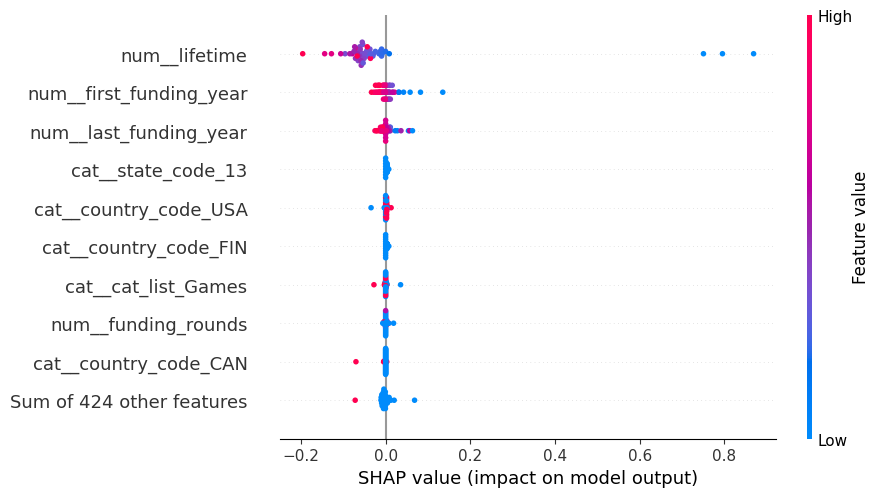

In [98]:
shap.plots.beeswarm(shap_values[:,:,0])

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Похоже, что значительное влияние имеет текущая продолжительность деятельности бизнеса, а также перый и последний год инвестиций в проект.
</div>

## Вывод проекта

Были получен датасет со стартапами, которые функционировали в период с 1980 по 2018 год. Данные были обработаны. Некоторые пропуски были заполнены. Были изучены количественные признаки, а также проведен корреляционный анализ признаков.
Далее была разработана модель машинного обучени, которая предсказывает закрытие стартапа или его дальнейшую работу с вероятностью 98% на тестовой выборке по метрике ROC-AUC.
Анализ важности признаков показал, что наибольший вес имеют признаки:
 - текущей продолжительности бизнеса;
 - первый и последний год инвестиций в стартап